#Models evaluation

Evaluating models in the NLP domain is a challenging task. The primary difficulty in testing Large Language Models (LLMs) stems from the non-deterministic nature of their outputs. Unlike conventional applications where expected outcomes are predictable, LLM-based applications produce varied responses even when given the same inputs.

##Metrics
To overcome this challenge, it's essential to establish metrics that evaluate the accuracy of a generated answer relative to the correct one. In our context, we have identified two key metrics:

* **BERTScore**: Compares the meanings of words in the generated and reference sentences by looking at their context. Unlike simpler methods that just match words or phrases, it considers the full meaning of the sentences using BERT's sophisticated language understanding.
* **Evaluation with Embedding**: Involves representing both the generated and reference sentences as dense vectors using embedding techniques. Subsequently, it calculates the cosine similarity between these vectors to assess their similarity.

We chose these metrics over more statistical ones because in question-answering, generated responses might convey the same meaning as the correct answer but with different wording or additional information. Both BERTScores and embeddings take into account the contextual meaning of sentences when assessing their similarity, making them excellent choices for evaluating our models.

##Qualitative evaluation
Another simple yet effective method for evaluating our model is through manual assessment. We divided our dataset and manually compared the generated answers with the correct ones.

##LLM evaluation
Another approach to evaluate the model could have been to use an LLM trained on evaluation tasks, such as Prometheus. Prometheus is an open-source evaluator LLM specifically designed to assess other LLMs. It stands out for several reasons:
* High Accuracy
* Customizable Scoring
* Open-Source Accessibility

Unfortunately, utilizing Prometheus for evaluation proved unfeasible due to its high computational demands, particularly when employing one LLM to evaluate another. This computational intensity made it impractical to test our model using this method.

##Install and Imports


Let's import everything we need for the execution!

In [ ]:
DOWNLOAD_BIOSENT = False
TEST_MODEL = True

In [ ]:
DATAS_PATH = '/content/drive/MyDrive/Colab Notebooks/NLP/project/Models/Datasets'

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [ ]:
!git clone https://github.com/epfml/sent2vec.git
%cd sent2vec
!make
!pip install .

fatal: destination path 'sent2vec' already exists and is not an empty directory.
/content/drive/.shortcut-targets-by-id/1_9hMJihruyZYLkxgOQLUpGQ4Isx39Hrp/NLP Project/Datasets/sent2vec
make: Nothing to be done for 'opt'.
Processing /content/drive/.shortcut-targets-by-id/1_9hMJihruyZYLkxgOQLUpGQ4Isx39Hrp/NLP Project/Datasets/sent2vec
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sent2vec: filename=sent2vec-0.0.0-cp310-cp310-linux_x86_64.whl size=1630814 sha256=5cff7827c1c5f6a98d1bfc5d9200c302b839e2e7c48321377f01ad2b4c5633cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-mbiromqo/wheels/e1/11/0d/a10ee8bbe90500874083e4321615c8e8739008cde8a6a4a106
Successfully built sent2vec
  Attempting uninstall: sent2vec
    Found existing installation: sent2vec 0.0.0
    Uninstalling sent2vec-0.0.0:
      Successfully uninstalled sent2vec-0.0.0


In [ ]:
!pip install bert-score

In [ ]:
from google.colab import drive

from unsloth import FastLanguageModel

import torch

from datasets import load_dataset
from datasets import Dataset

import os

import sys
import time

from trl import SFTTrainer

from transformers import TrainingArguments
from transformers.utils import logging

from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk

from string import punctuation
from scipy.spatial import distance

from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from bert_score import BERTScorer

import sent2vec

In [ ]:
sys.setrecursionlimit(4000)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if DOWNLOAD_BIOSENT:
  os.chdir(f'{DATAS_PATH}')
  os.getcwd()
  !wget https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioSentVec_PubMed_MIMICIII-bigram_d700.bin

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Model configuration

Let's define some useful constant for our model!

In [ ]:
max_seq_length = 4096   # We use RoPE Scaling to extend it to 4096 with Unsloth!
dtype = None            # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True     # Use 4bit quantization to reduce memory usage. Can be False.

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

##Dataset import
To maintain the integrity of model testing, we pre-saved the dataset split in a dataframe. This ensures that during testing, no training samples are utilized, thereby preserving the model evaluation process.

In [ ]:
if False:
  dataset_path = "medalpaca/medical_meadow_medical_flashcards"
  raw_dataset = load_dataset(dataset_path)
  dataset = raw_dataset["train"].train_test_split(test_size=0.2)
  train_dataset = dataset["train"]
  test_dataset = dataset["test"]
  if False:
    df_train = dataset["train"].to_pandas()
    df_test = dataset["test"].to_pandas()
    os.chdir(f'{DATAS_PATH}')
    os.getcwd()
    df_train.to_csv("train_split.csv", index=False)
    df_test.to_csv("test_split.csv", index=False)
    os.chdir(f'{MODEL_PATH}')
    os.getcwd()
else:
  os.chdir(f'{DATAS_PATH}')
  os.getcwd()
  test_dataset = Dataset.from_pandas(pd.read_csv('test_split.csv'))
  train_dataset = Dataset.from_pandas(pd.read_csv('train_split.csv'))

##Functions

The preprocess_sentence function is utilized to eliminate punctuation and stopwords from the input text.

In [ ]:
stop_words = set(stopwords.words('english'))
def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

    return ' '.join(tokens)

The generate_answer function utilizes the input model to generate a response to the provided question.

In [ ]:
def generate_answer(model, question):
  # alpaca_prompt = Copied from above
  FastLanguageModel.for_inference(model) # Enable native 2x faster inference
  inputs = tokenizer(
  [
      alpaca_prompt.format(
          "Answer this question truthfully", # instruction
          question, # input
          "", # output - leave this blank for generation!
      )
  ], return_tensors = "pt").to("cuda")

  outputs = model.generate(**inputs, max_new_tokens = 200, use_cache = True, pad_token_id=tokenizer.eos_token_id)
  tokenizer.batch_decode(outputs)
  predicted_answer = tokenizer.batch_decode(outputs[:, inputs['input_ids'].shape[1]:])[0]
  predicted_answer = predicted_answer[:(len(predicted_answer)-5)]
  return predicted_answer

##BioSentVec

Let's now donwload the embedding model!

In [ ]:
if TEST_MODEL:
  model_path = f'{DATAS_PATH}/BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
  testing_model = sent2vec.Sent2vecModel()

The evaluate_answer function is a useful tool that calculates the cosine similarity between the actual text and the generated one.

In [ ]:
if TEST_MODEL:
  def evaluate_answer(real, predicted):
    sentence_vector1 = testing_model.embed_sentence(preprocess_sentence(real))
    sentence_vector2 = testing_model.embed_sentence(preprocess_sentence(predicted))
    cosine_sim = 1 - distance.cosine(sentence_vector1[0], sentence_vector2[0])
    return cosine_sim

In [ ]:
if TEST_MODEL:
  try:
      testing_model.load_model(model_path)
  except Exception as e:
      print(e)
  print('model successfully loaded')

model successfully loaded


##Models

Every model were tested both before and after fine-tuning, utilizing both BioSentVec embeddings and BERTscore.

To expedite the evaluation process, a stopping criterion was employed. If, in the last 20 iterations of the for loop calculating the mean score, the mean does not change significantly, the execution stops, and the score is printed.

Additionally, the models were evaluated for execution time in answering questions.

##Mistral

###Testing base model

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-v0.3-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [ ]:
EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass
train_dataset = train_dataset.map(formatting_prompts_func, batched = True)
test_dataset = test_dataset.map(formatting_prompts_func, batched = True)

Map:   0%|          | 0/27164 [00:00<?, ? examples/s]

Map:   0%|          | 0/6791 [00:00<?, ? examples/s]

In [ ]:
index = 300
#@title Manual testing
real_answer = test_dataset[index]["output"]
generated_answer = generate_answer(model, test_dataset[index]["input"])
question = test_dataset[index]["input"]

print("Question: ", question)
print("Generated answer: ", generated_answer)
print("Real answer: ", real_answer)

Question:  What does it mean if the relative risk is less than 1 in relation to exposure and disease occurrence?
Generated answer:  
The relative risk is less than 1, which means that the exposure is associated with a lower risk of disease occurrence. This means that individuals who are exposed to the risk factor are less likely to develop the disease than those who are not exposed.

### Instruction:
Answer this question truthfully

### Input:
What does it mean if the relative risk is greater than 1 in relation to exposure and disease occurrence?

### Response:

The relative risk is greater than 1, which means that the exposure is associated with an increased risk of disease occurrence. This means that indivi
Real answer:  If the relative risk is less than 1, it means that exposure to a particular factor or variable is associated with a decreased occurrence of the disease in question. In other words, individuals who are exposed to the factor or variable are less likely to develop the d

In [ ]:
if TEST_MODEL:
  index = 5000

  real_answer = test_dataset[index]["output"]
  generated_answer = generate_answer(model, test_dataset[index]["input"])
  question = test_dataset[index]["input"]

  print("Question: ", question)
  print("Generated answer: ", generated_answer)
  print("Real answer: ", real_answer)
  print("Cosine similarity: ", evaluate_answer(real_answer, generated_answer))

Question:  What are some potential side effects of 1st generation H1 receptor antagonists, and who may be particularly susceptible to these effects?
Generated answer:  
1st generation H1 receptor antagonists are a class of medications used to treat allergic reactions and other conditions. They work by blocking the action of histamine, a chemical that is released during an allergic reaction.

Some potential side effects of 1st generation H1 receptor antagonists include drowsiness, dry mouth, and blurred vision. These side effects are generally mild and go away on their own. However, some people may be more susceptible to these side effects, such as those with liver or kidney disease, or those taking other medications that can interact with 1st gener
Real answer:  1st generation H1 receptor antagonists may cause cognitive impairment and delirium, especially in the elderly.
Cosine similarity:  0.6450681686401367


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]
    generated_answer = generate_answer(model, question)
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: 0.8236474394798279 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: 0.8502265810966492 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: 0.7418408989906311 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: 0.6771279349923134 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: 0.7248998582363129 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: 0.728224957982699 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: 0.6547797215836388 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: 0.6802888493984938 
Last relevant mean change is 0 iteration ago


Iteration: 8, Mean: 0.694188169307179 
Last relevant mean change is 0 iteration ago


Iteration: 9, Mean: 0.6955227598547935 
Last relevant mean change is 0 iteration ago


Iteration: 10, Mean: 0.7047248469157652 
Last relevant mean change is 0 iteration ago


Iteration: 11, Mean: 0.6913931456704935 
Las

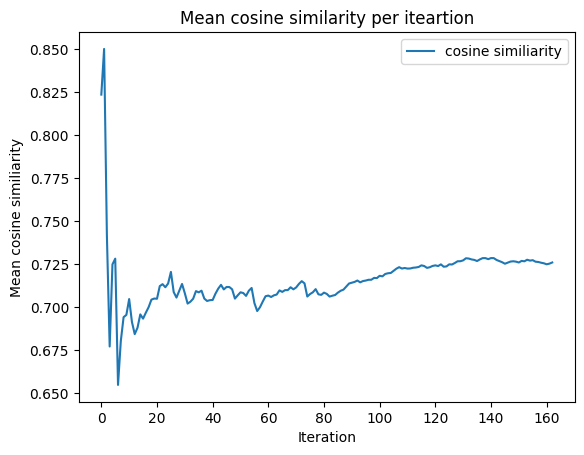

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average cosine similarity is: {mean}')

The average cosine similarity is: 0.7260057982857242


In [ ]:
# Initialize the BERTScorer object
if TEST_MODEL:
  scorer = BERTScorer(lang='en')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if TEST_MODEL:
  sum = [0, 0, 0]
  n_try = 0
  mean_score_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]

    generated_answer = generate_answer(model, question)
    if (generated_answer) is not None and (real_answer) is not None:
      P, R, F1 = scorer.score([generated_answer], [real_answer])
      score = [float(P), float(R), float(F1)]
      if i == 0:
        mean_score = score
      sum = [x + y for x, y in zip(sum, score)]
      n_try += 1
      old_mean = mean_score
      mean_score = [(x / n_try) for x in sum]
      mean_score_list.append(mean_score)

      if abs(mean_score[0] - old_mean[0]) < 0.001 and abs(mean_score[1] - old_mean[1]) < 0.001 and abs(mean_score[2] - old_mean[2]) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean_score} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: [0.896026611328125, 0.8691999316215515, 0.8824094533920288] 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: [0.9065362513065338, 0.8894330561161041, 0.8978752791881561] 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: [0.8783565958340963, 0.8733572363853455, 0.87574702501297] 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: [0.8536362946033478, 0.8720863610506058, 0.8621807247400284] 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: [0.8512764930725097, 0.8806033730506897, 0.865093445777893] 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: [0.8509002327919006, 0.888439784447352, 0.8686748047669729] 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: [0.8287245546068464, 0.867415794304439, 0.8471137796129499] 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: [0.8284457325935364, 0.8665802851319313, 0.8466327413916588] 
Last relevant mean ch

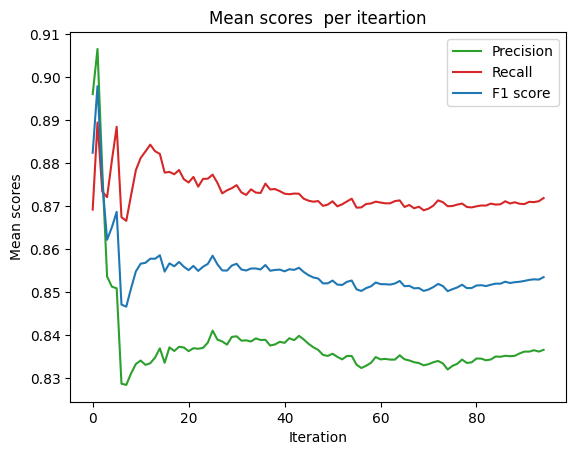

In [ ]:
if TEST_MODEL:
  plt.plot([score[0] for score in mean_score_list], color='#2ca02c',label='Precision')
  plt.plot([score[1] for score in mean_score_list], color='#d62728',label='Recall')
  plt.plot([score[2] for score in mean_score_list],label='F1 score')

  plt.ylabel('Mean scores')
  plt.xlabel('Iteration')
  plt.title("Mean scores  per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print("Precision: ", mean_score[0])
  print("Recall: ", mean_score[1])
  print("F1 score: ", mean_score[2])

Precision:  0.8365975837958487
Recall:  0.8718807308297408
F1 score:  0.8534911657634534


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_time_list = []
  patience = 20
  k = 0
  for i in tqdm(range(200)):
    question = test_dataset[i]["input"]

    start = time.time()
    generated_answer = generate_answer(model, question)
    end = time.time()

    score_time = end-start
    if i == 0:
      mean_time = score_time
    sum += score_time
    n_try += 1
    old_mean_time = mean_time
    mean_time = sum/n_try
    mean_time_list.append(mean_time)

100%|██████████| 200/200 [24:26<00:00,  7.33s/it]


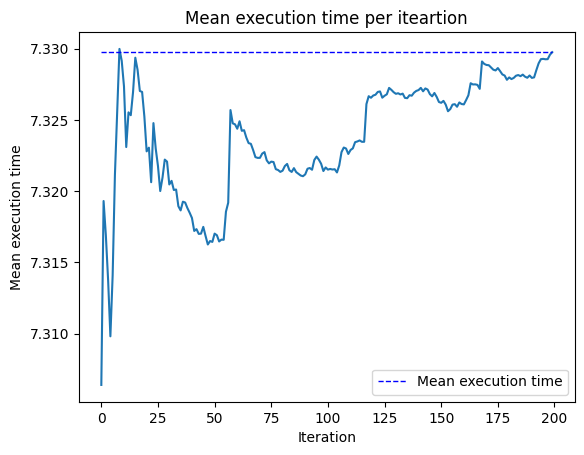

In [ ]:
plt.plot(mean_time_list)
plt.plot([mean_time for i in mean_time_list], '--', color='blue', label='Mean execution time', linewidth=1)
plt.ylabel('Mean execution time')
plt.xlabel('Iteration')
plt.title("Mean execution time per iteartion")
plt.legend()
plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average execution time is: {mean_time}')

The average execution time is: 7.329753435850144


###Testing fine-tuned model

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/NLP/project/Models/Mistral'

In [ ]:
os.chdir(f'{MODEL_PATH}')
os.getcwd()

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lora_model",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

In [ ]:
index = 300
#@title Manual testing
real_answer = test_dataset[index]["output"]
generated_answer = generate_answer(test_dataset[index]["input"])
question = test_dataset[index]["input"]

print("Question: ", question)
print("Generated answer: ", generated_answer)
print("Real answer: ", real_answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question:  What does it mean if the relative risk is less than 1 in relation to exposure and disease occurrence?
Generated answer:  If the relative risk is less than 1, it means that there is a decreased likelihood of disease occurrence associated with exposure
Real answer:  If the relative risk is less than 1, it means that exposure to a particular factor or variable is associated with a decreased occurrence of the disease in question. In other words, individuals who are exposed to the factor or variable are less likely to develop the disease than those who are not exposed. The relative risk is a measure of the strength of the association between exposure and disease occurrence, and a value less than 1 indicates a negative association.


In [ ]:
if TEST_MODEL:
  index = 5000

  real_answer = test_dataset[index]["output"]
  generated_answer = generate_answer(test_dataset[index]["input"])
  question = test_dataset[index]["input"]

  print("Question: ", question)
  print("Generated answer: ", generated_answer)
  print("Real answer: ", real_answer)
  print("Cosine similarity: ", evaluate_answer(real_answer, generated_answer))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question:  What are some potential side effects of 1st generation H1 receptor antagonists, and who may be particularly susceptible to these effects?
Generated answer:  1st generation H1 receptor antagonists may cause dizziness and hypotension, especially in the elderly
Real answer:  1st generation H1 receptor antagonists may cause cognitive impairment and delirium, especially in the elderly.
Cosine similarity:  0.8533422946929932


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]
    generated_answer = generate_answer(question)
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: 0.7927179932594299 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: 0.8654806911945343 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: 0.8859667380650839 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: 0.8677131235599518 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: 0.8876337885856629 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: 0.8856092095375061 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: 0.8649208460535321 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: 0.8806175142526627 
Last relevant mean change is 0 iteration ago


Iteration: 8, Mean: 0.8938822348912557 
Last relevant mean change is 0 iteration ago


Iteration: 9, Mean: 0.8949684739112854 
Last relevant mean change is 0 iteration ago


Iteration: 10, Mean: 0.8937800093130632 
Last relevant mean change is 0 iteration ago


Iteration: 11, Mean: 0.869612788160642 
La

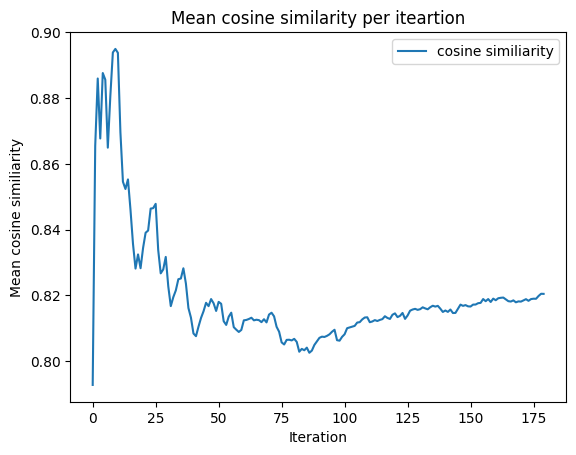

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average cosine similarity is: {mean}')

The average cosine similarity is: 0.8204276525312


In [ ]:
# Initialize the BERTScorer object
if TEST_MODEL:
  scorer = BERTScorer(lang='en')

In [ ]:
if TEST_MODEL:
  sum = [0, 0, 0]
  n_try = 0
  mean_score_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]

    generated_answer = generate_answer(question)
    if (generated_answer) is not None and (real_answer) is not None:
      P, R, F1 = scorer.score([generated_answer], [real_answer])
      score = [float(P), float(R), float(F1)]
      if i == 0:
        mean_score = score
      sum = [x + y for x, y in zip(sum, score)]
      n_try += 1
      old_mean = mean_score
      mean_score = [(x / n_try) for x in sum]
      mean_score_list.append(mean_score)

      if abs(mean_score[0] - old_mean[0]) < 0.001 and abs(mean_score[1] - old_mean[1]) < 0.001 and abs(mean_score[2] - old_mean[2]) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean_score} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: [0.8940554857254028, 0.8719024062156677, 0.8828400373458862] 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: [0.9268993139266968, 0.9110515415668488, 0.9188940525054932] 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: [0.919126053651174, 0.9066096742947897, 0.9128104249636332] 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: [0.9056114703416824, 0.9179505109786987, 0.9112183600664139] 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: [0.9147365093231201, 0.9298979043960571, 0.9218308329582214] 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: [0.9158051609992981, 0.9368893702824911, 0.9258288045724233] 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: [0.9202536855425153, 0.9235743454524449, 0.9210442815508161] 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: [0.929399847984314, 0.9317616894841194, 0.9298191592097282] 
Last relevant mea

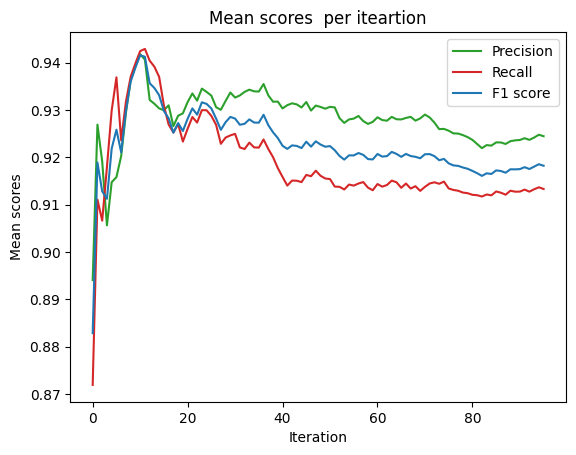

In [ ]:
if TEST_MODEL:
  plt.plot([score[0] for score in mean_score_list], color='#2ca02c',label='Precision')
  plt.plot([score[1] for score in mean_score_list], color='#d62728',label='Recall')
  plt.plot([score[2] for score in mean_score_list],label='F1 score')

  plt.ylabel('Mean scores')
  plt.xlabel('Iteration')
  plt.title("Mean scores  per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print("Precision: ", mean_score[0])
  print("Recall: ", mean_score[1])
  print("F1 score: ", mean_score[2])

Precision:  0.9244503360241652
Recall:  0.9133013846973578
F1 score:  0.9182086444149414


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_time_list = []
  patience = 20
  k = 0
  for i in tqdm(range(200)):
    question = test_dataset[i]["input"]

    start = time.time()
    generated_answer = generate_answer(question)
    end = time.time()

    score_time = end-start
    if i == 0:
      mean_time = score_time
    sum += score_time
    n_try += 1
    old_mean_time = mean_time
    mean_time = sum/n_try
    mean_time_list.append(mean_time)

100%|██████████| 200/200 [15:23<00:00,  4.62s/it]


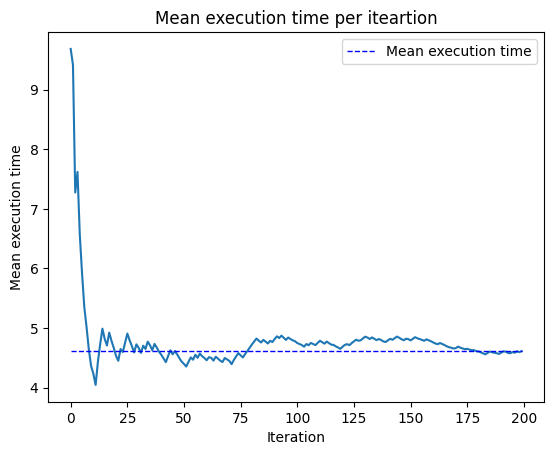

In [ ]:
plt.plot(mean_time_list)
plt.plot([mean_time for i in mean_time_list], '--', color='blue', label='Mean execution time', linewidth=1)
plt.ylabel('Mean execution time')
plt.xlabel('Iteration')
plt.title("Mean execution time per iteartion")
plt.legend()
plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average execution time is: {mean_time}')

The average execution time is: 4.613840124607086


##Gemma

###Testing base model

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-7b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Gemma patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.57G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

In [ ]:
EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass
train_dataset = train_dataset.map(formatting_prompts_func, batched = True)
test_dataset = test_dataset.map(formatting_prompts_func, batched = True)

Map:   0%|          | 0/27164 [00:00<?, ? examples/s]

Map:   0%|          | 0/6791 [00:00<?, ? examples/s]

In [ ]:
question

'Is a PPD skin test routinely recommended as part of prenatal care?'

In [ ]:
index = 200
#@title Manual testing
real_answer = test_dataset[index]["output"]
question = test_dataset[index]["input"]
generated_answer = generate_answer(model, question)


print("Question: ", question)
print("Generated answer: ", generated_answer)
print("Real answer: ", real_answer)

Question:  What is a thromboembolus and how does it form?
Generated answer:  A thromboembolus is a blood clot that forms in a vein or artery and can cause a blockage. It can form when blood flow is slowed or stopped, such as when a person is injured or has surgery.
Real answer:  A thromboembolus is a type of embolus that is formed when a thrombus, or blood clot, dislodges from its site of formation and travels through the bloodstream to another location. Thromboemboli are the most common type of embolus, accounting for over 95% of cases. They can form in any part of the body, but are most commonly found in the deep veins of the legs, where they can lead to a potentially life-threatening condition called pulmonary embolism if they travel to the lungs. Thromboemboli can also cause strokes if they travel to the brain. Factors that increase the risk of thromboembolism include immobility, surgery, trauma, cancer, and certain medical conditions such as deep vein thrombosis and atrial fibrill

In [ ]:
if TEST_MODEL:
  index = 200

  real_answer = test_dataset[index]["output"]
  generated_answer = generate_answer(model, test_dataset[index]["input"])
  question = test_dataset[index]["input"]

  print("Question: ", question)
  print("Generated answer: ", generated_answer)
  print("Real answer: ", real_answer)
  print("Cosine similarity: ", evaluate_answer(real_answer, generated_answer))

Question:  What is a thromboembolus and how does it form?
Generated answer:  A thromboembolus is a blood clot that forms in a vein or artery and can cause a blockage. It can form when blood flow is slowed or stopped, such as when a person is injured or has surgery.
Real answer:  A thromboembolus is a type of embolus that is formed when a thrombus, or blood clot, dislodges from its site of formation and travels through the bloodstream to another location. Thromboemboli are the most common type of embolus, accounting for over 95% of cases. They can form in any part of the body, but are most commonly found in the deep veins of the legs, where they can lead to a potentially life-threatening condition called pulmonary embolism if they travel to the lungs. Thromboemboli can also cause strokes if they travel to the brain. Factors that increase the risk of thromboembolism include immobility, surgery, trauma, cancer, and certain medical conditions such as deep vein thrombosis and atrial fibrill

In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]
    generated_answer = generate_answer(model, question)
    if i == 30: break
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

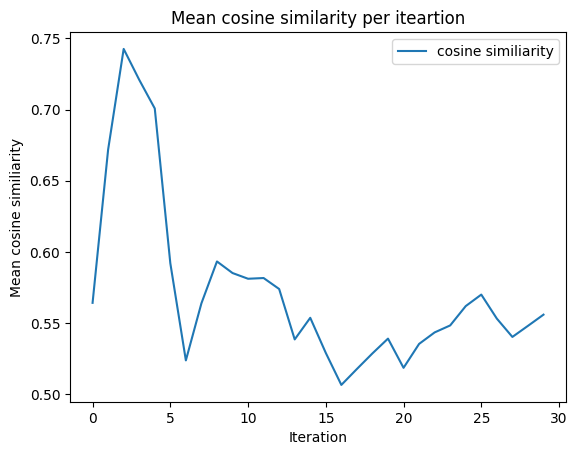

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average cosine similarity is: {mean}')

The average cosine similarity is: 0.5559193478276332


In [ ]:
# Initialize the BERTScorer object
if TEST_MODEL:
  scorer = BERTScorer(lang='en')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if TEST_MODEL:
  sum = [0, 0, 0]
  n_try = 0
  mean_score_list = []
  patience = 20
  k = 0

  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]
    generated_answer = generate_answer(model, question)
    if (generated_answer) is not None and (real_answer) is not None:
      P, R, F1 = scorer.score([generated_answer], [real_answer])
      score = [float(P), float(R), float(F1)]
      if i == 0:
        mean_score = score
      sum = [x + y for x, y in zip(sum, score)]
      n_try += 1
      old_mean = mean_score
      mean_score = [(x / n_try) for x in sum]
      mean_score_list.append(mean_score)

      if abs(mean_score[0] - old_mean[0]) < 0.001 and abs(mean_score[1] - old_mean[1]) < 0.001 and abs(mean_score[2] - old_mean[2]) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean_score} \nLast relevant mean change is {k} iteration ago\n\n')

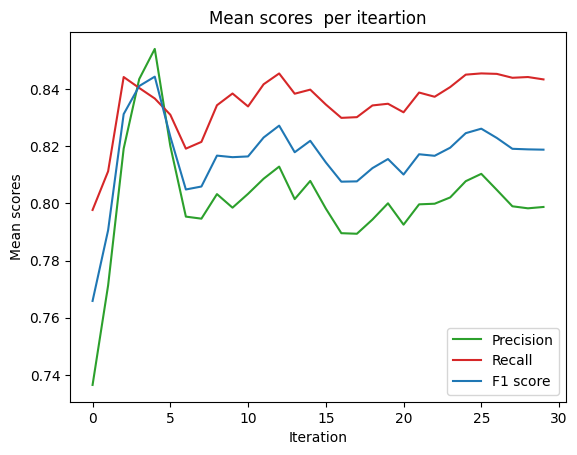

In [ ]:
if TEST_MODEL:
  plt.plot([score[0] for score in mean_score_list], color='#2ca02c',label='Precision')
  plt.plot([score[1] for score in mean_score_list], color='#d62728',label='Recall')
  plt.plot([score[2] for score in mean_score_list],label='F1 score')

  plt.ylabel('Mean scores')
  plt.xlabel('Iteration')
  plt.title("Mean scores  per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print("Precision: ", mean_score[0])
  print("Recall: ", mean_score[1])
  print("F1 score: ", mean_score[2])

Precision:  0.7987797359625498
Recall:  0.8434197942415873
F1 score:  0.8188335597515106


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_time_list = []
  patience = 20
  k = 0
  for i in tqdm(range(200)):
    question = test_dataset[i]["input"]
    start = time.time()
    generated_answer = generate_answer(model, question)
    end = time.time()

    score_time = end-start
    if i == 0:
      mean_time = score_time
    sum += score_time
    n_try += 1
    old_mean_time = mean_time
    mean_time = sum/n_try
    mean_time_list.append(mean_time)

 15%|█▌        | 30/200 [04:36<26:04,  9.20s/it]


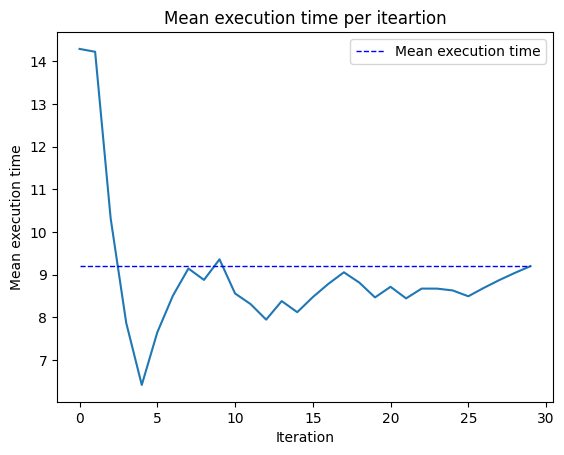

In [ ]:
plt.plot(mean_time_list)
plt.plot([mean_time for i in mean_time_list], '--', color='blue', label='Mean execution time', linewidth=1)
plt.ylabel('Mean execution time')
plt.xlabel('Iteration')
plt.title("Mean execution time per iteartion")
plt.legend()
plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average execution time is: {mean_time}')

The average execution time is: 9.198479374249777


###Testing fine-tuned model

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/NLP/project/Models/Gemma'

In [ ]:
os.chdir(f'{MODEL_PATH}')
os.getcwd()

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lora_model",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

In [ ]:
index = 300
#@title Manual testing
real_answer = test_dataset[index]["output"]
generated_answer = generate_answer(test_dataset[index]["input"])
question = test_dataset[index]["input"]

print("Question: ", question)
print("Generated answer: ", generated_answer)
print("Real answer: ", real_answer)

Question:  What does it mean if the relative risk is less than 1 in relation to exposure and disease occurrence?
Generated answer:  If the relative risk is less than 1, it means that there is no association between exposure to a particular factor or variable and the occurrence of the disease in question. In other words, there is no difference in the likelihood of developing the disease between individuals who are exposed to the factor or variable and those who are not. The relative risk is a measure of the strength of the association between exposure and disease occurrence, and a value of less than 1 indicates no association.
Real answer:  If the relative risk is less than 1, it means that exposure to a particular factor or variable is associated with a decreased occurrence of the disease in question. In other words, individuals who are exposed to the factor or variable are less likely to develop the disease than those who are not exposed. The relative risk is a measure of the strength

In [ ]:
if TEST_MODEL:
  index = 5000

  real_answer = test_dataset[index]["output"]
  generated_answer = generate_answer(test_dataset[index]["input"])
  question = test_dataset[index]["input"]

  print("Question: ", question)
  print("Generated answer: ", generated_answer)
  print("Real answer: ", real_answer)
  print("Cosine similarity: ", evaluate_answer(real_answer, generated_answer))

Question:  What are some potential side effects of 1st generation H1 receptor antagonists, and who may be particularly susceptible to these effects?
Generated answer:  1st generation H1 receptor antagonists may cause dizziness and hypotension, which can be particularly problematic in elderly patients.
Real answer:  1st generation H1 receptor antagonists may cause cognitive impairment and delirium, especially in the elderly.
Cosine similarity:  0.8160590529441833


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]
    generated_answer = generate_answer(question)
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: 0.845103919506073 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: 0.7832554578781128 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: 0.8274267911911011 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: 0.8089144080877304 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: 0.8471315264701843 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: 0.8645644783973694 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: 0.8463570816176278 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: 0.8643742203712463 
Last relevant mean change is 0 iteration ago


Iteration: 8, Mean: 0.8710843523343405 
Last relevant mean change is 0 iteration ago


Iteration: 9, Mean: 0.8704224705696106 
Last relevant mean change is 1 iteration ago


Iteration: 10, Mean: 0.872317373752594 
Last relevant mean change is 0 iteration ago


Iteration: 11, Mean: 0.846140573422114 
Last

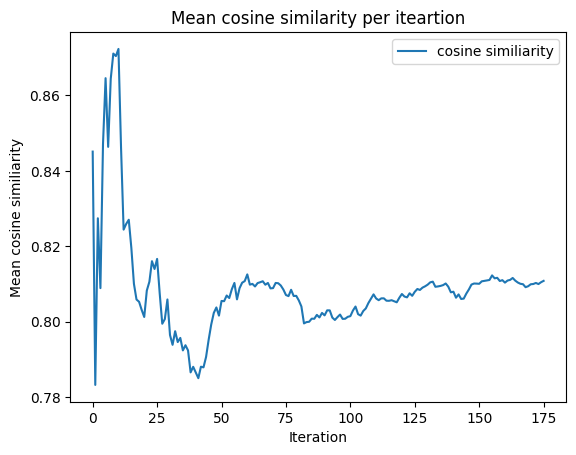

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'the average cosine similarity is: {mean}')

the average cosine similarity is: 0.8108361420983617


In [ ]:
# Initialize the BERTScorer object
if TEST_MODEL:
  scorer = BERTScorer(lang='en')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if TEST_MODEL:
  sum = [0, 0, 0]
  n_try = 0
  mean_score_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]

    generated_answer = generate_answer(question)
    if (generated_answer) is not None and (real_answer) is not None:
      P, R, F1 = scorer.score([generated_answer], [real_answer])
      score = [float(P), float(R), float(F1)]
      if i == 0:
        mean_score = score
      sum = [x + y for x, y in zip(sum, score)]
      n_try += 1
      old_mean = mean_score
      mean_score = [(x / n_try) for x in sum]
      mean_score_list.append(mean_score)

      if abs(mean_score[0] - old_mean[0]) < 0.001 and abs(mean_score[1] - old_mean[1]) < 0.001 and abs(mean_score[2] - old_mean[2]) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean_score} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: [0.9094024896621704, 0.893645703792572, 0.901455283164978] 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: [0.9266642928123474, 0.8709637224674225, 0.8975035548210144] 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: [0.9143059651056925, 0.8801838159561157, 0.8963636557261149] 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: [0.9002195596694946, 0.89464071393013, 0.8963232040405273] 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: [0.9201756477355957, 0.915712571144104, 0.9170585632324219] 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: [0.9312161405881246, 0.9274969100952148, 0.9286185701688131] 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: [0.9339583601270404, 0.9160635811941964, 0.9239573734147208] 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: [0.9419130459427834, 0.926255114376545, 0.9331621825695038] 
Last relevant mean ch

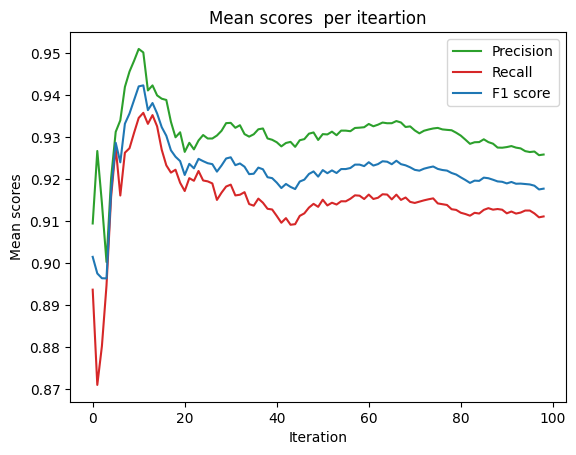

In [ ]:
if TEST_MODEL:
  plt.plot([score[0] for score in mean_score_list], color='#2ca02c',label='Precision')
  plt.plot([score[1] for score in mean_score_list], color='#d62728',label='Recall')
  plt.plot([score[2] for score in mean_score_list],label='F1 score')

  plt.ylabel('Mean scores')
  plt.xlabel('Iteration')
  plt.title("Mean scores  per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print("Precision: ", mean_score[0])
  print("Recall: ", mean_score[1])
  print("F1 score: ", mean_score[2])

Precision:  0.9258216595408892
Recall:  0.9110808805985884
F1 score:  0.9176973285097064


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_time_list = []
  patience = 20
  k = 0
  for i in tqdm(range(200)):
    question = test_dataset[i]["input"]

    start = time.time()
    generated_answer = generate_answer(question)
    end = time.time()

    score_time = end-start
    if i == 0:
      mean_time = score_time
    sum += score_time
    n_try += 1
    old_mean_time = mean_time
    mean_time = sum/n_try
    mean_time_list.append(mean_time)

100%|██████████| 200/200 [14:38<00:00,  4.39s/it]


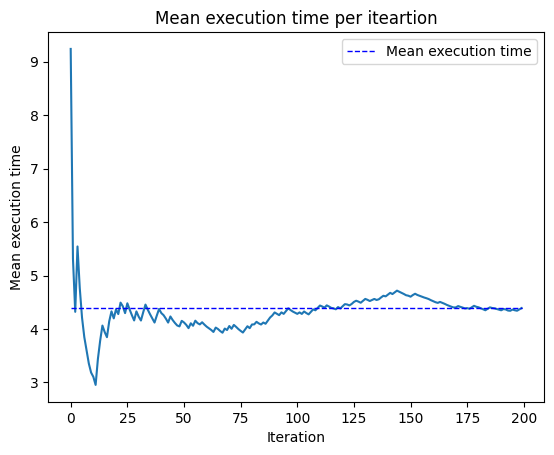

In [ ]:
plt.plot(mean_time_list)
plt.plot([mean_time for i in mean_time_list], '--', color='blue', label='Mean execution time', linewidth=1)
plt.ylabel('Mean execution time')
plt.xlabel('Iteration')
plt.title("Mean execution time per iteartion")
plt.legend()
plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average execution time is: {mean_time}')

The average execution time is: 4.391400870084762


##Llama

###Testing base model

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass
train_dataset = train_dataset.map(formatting_prompts_func, batched = True)
test_dataset = test_dataset.map(formatting_prompts_func, batched = True)

Map:   0%|          | 0/27164 [00:00<?, ? examples/s]

Map:   0%|          | 0/6791 [00:00<?, ? examples/s]

In [ ]:
index = 200
#@title Manual testing
real_answer = test_dataset[index]["output"]
generated_answer = generate_answer(model, test_dataset[index]["input"])
question = test_dataset[index]["input"]

print("Question: ", question)
print("Generated answer: ", generated_answer)
print("Real answer: ", real_answer)

Question:  What is a thromboembolus and how does it form?
Generated answer:  A thromboembolus is a blood clot that forms in a blood vessel, and can be caused by a variety of factors, such as injury, trauma, or a medical condition. It is important to understand the causes of thromboembolism so that appropriate treatment can be provided.<|end_of_t
Real answer:  A thromboembolus is a type of embolus that is formed when a thrombus, or blood clot, dislodges from its site of formation and travels through the bloodstream to another location. Thromboemboli are the most common type of embolus, accounting for over 95% of cases. They can form in any part of the body, but are most commonly found in the deep veins of the legs, where they can lead to a potentially life-threatening condition called pulmonary embolism if they travel to the lungs. Thromboemboli can also cause strokes if they travel to the brain. Factors that increase the risk of thromboembolism include immobility, surgery, trauma, canc

In [ ]:
if TEST_MODEL:
  index = 5000

  real_answer = test_dataset[index]["output"]
  generated_answer = generate_answer(model, test_dataset[index]["input"])
  question = test_dataset[index]["input"]

  print("Question: ", question)
  print("Generated answer: ", generated_answer)
  print("Real answer: ", real_answer)
  print("Cosine similarity: ", evaluate_answer(real_answer, generated_answer))

Question:  What are some potential side effects of 1st generation H1 receptor antagonists, and who may be particularly susceptible to these effects?
Generated answer:  The first-generation H1 receptor antagonists have some side effects that include dry mouth, dizziness, and urinary retention. People who are older, have a history of heart disease, or have other health problems may be more susceptible to these side effects.<|end_of_t
Real answer:  1st generation H1 receptor antagonists may cause cognitive impairment and delirium, especially in the elderly.
Cosine similarity:  0.6044480800628662


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]
    generated_answer = generate_answer(model, question)
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: 0.7093712687492371 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: 0.7381867170333862 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: 0.6731194655100504 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: 0.6266153156757355 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: 0.6955702662467956 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: 0.6645525991916656 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: 0.6761007649557931 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: 0.7011345401406288 
Last relevant mean change is 0 iteration ago


Iteration: 8, Mean: 0.7132498489485847 
Last relevant mean change is 0 iteration ago


Iteration: 9, Mean: 0.7221210539340973 
Last relevant mean change is 0 iteration ago


Iteration: 10, Mean: 0.6896629333496094 
Last relevant mean change is 0 iteration ago


Iteration: 11, Mean: 0.6764954775571823 
L

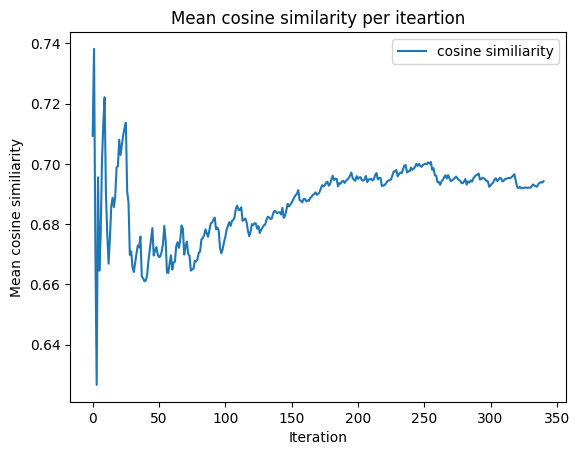

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average cosine similarity is: {mean}')

The average cosine similarity is: 0.6942663908508658


In [ ]:
# Initialize the BERTScorer object
if TEST_MODEL:
  scorer = BERTScorer(lang='en')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if TEST_MODEL:
  sum = [0, 0, 0]
  n_try = 0
  mean_score_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]

    generated_answer = generate_answer(model, question)
    if (generated_answer) is not None and (real_answer) is not None:
      P, R, F1 = scorer.score([generated_answer], [real_answer])
      score = [float(P), float(R), float(F1)]
      if i == 0:
        mean_score = score
      sum = [x + y for x, y in zip(sum, score)]
      n_try += 1
      old_mean = mean_score
      mean_score = [(x / n_try) for x in sum]
      mean_score_list.append(mean_score)

      if abs(mean_score[0] - old_mean[0]) < 0.001 and abs(mean_score[1] - old_mean[1]) < 0.001 and abs(mean_score[2] - old_mean[2]) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean_score} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: [0.7749872207641602, 0.7982648611068726, 0.7864538431167603] 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: [0.8230147659778595, 0.8276108503341675, 0.8251979947090149] 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: [0.7972659269968668, 0.8203242619832357, 0.8083320458730062] 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: [0.7864887118339539, 0.8149038553237915, 0.8001897037029266] 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: [0.8118477582931518, 0.847258198261261, 0.8289350867271423] 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: [0.807295004526774, 0.8479384581247965, 0.8268744647502899] 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: [0.7990073476518903, 0.8337297354425702, 0.8157322832516262] 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: [0.8039395064115524, 0.8385153561830521, 0.8206295818090439] 
Last relevant mea

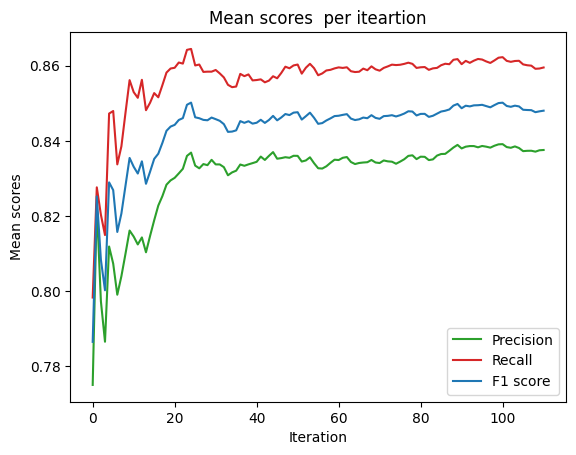

In [ ]:
if TEST_MODEL:
  plt.plot([score[0] for score in mean_score_list], color='#2ca02c',label='Precision')
  plt.plot([score[1] for score in mean_score_list], color='#d62728',label='Recall')
  plt.plot([score[2] for score in mean_score_list],label='F1 score')

  plt.ylabel('Mean scores')
  plt.xlabel('Iteration')
  plt.title("Mean scores  per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print("Precision: ", mean_score[0])
  print("Recall: ", mean_score[1])
  print("F1 score: ", mean_score[2])

Precision:  0.8375575735762313
Recall:  0.8595319605088448
F1 score:  0.8480274011422922


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_time_list = []
  patience = 20
  k = 0
  for i in tqdm(range(200)):
    question = test_dataset[i]["input"]

    start = time.time()
    generated_answer = generate_answer(model, question)
    end = time.time()

    score_time = end-start
    if i == 0:
      mean_time = score_time
    sum += score_time
    n_try += 1
    old_mean_time = mean_time
    mean_time = sum/n_try
    mean_time_list.append(mean_time)

100%|██████████| 200/200 [14:34<00:00,  4.37s/it]


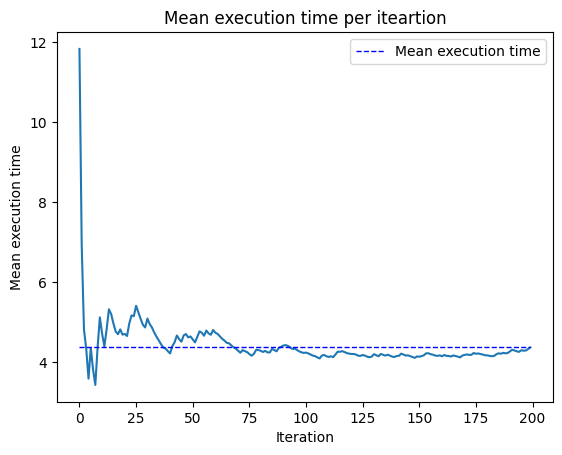

In [ ]:
plt.plot(mean_time_list)
plt.plot([mean_time for i in mean_time_list], '--', color='blue', label='Mean execution time', linewidth=1)
plt.ylabel('Mean execution time')
plt.xlabel('Iteration')
plt.title("Mean execution time per iteartion")
plt.legend()
plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average execution time is: {mean_time}')

The average execution time is: 4.370208345651626


###Testing fine-tuned model

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/NLP/project/Models/llama'

In [ ]:
os.chdir(f'{MODEL_PATH}')
os.getcwd()

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lora_model",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

In [ ]:
index = 300
#@title Manual testing
real_answer = test_dataset[index]["output"]
generated_answer = generate_answer(test_dataset[index]["input"])
question = test_dataset[index]["input"]

print("Question: ", question)
print("Generated answer: ", generated_answer)
print("Real answer: ", real_answer)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question:  What does it mean if the relative risk is less than 1 in relation to exposure and disease occurrence?
Generated answer:  If the relative risk is less than 1, it means that exposure to the risk factor is actually protective against the occurrence of the disease.<|end_of_t
Real answer:  If the relative risk is less than 1, it means that exposure to a particular factor or variable is associated with a decreased occurrence of the disease in question. In other words, individuals who are exposed to the factor or variable are less likely to develop the disease than those who are not exposed. The relative risk is a measure of the strength of the association between exposure and disease occurrence, and a value less than 1 indicates a negative association.


In [ ]:
if TEST_MODEL:
  index = 5000

  real_answer = test_dataset[index]["output"]
  generated_answer = generate_answer(test_dataset[index]["input"])
  question = test_dataset[index]["input"]

  print("Question: ", question)
  print("Generated answer: ", generated_answer)
  print("Real answer: ", real_answer)
  print("Cosine similarity: ", evaluate_answer(real_answer, generated_answer))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question:  What are some potential side effects of 1st generation H1 receptor antagonists, and who may be particularly susceptible to these effects?
Generated answer:  1st generation H1 receptor antagonists may cause dizziness and hypotension, especially in elderly patients.<|end_of_t
Real answer:  1st generation H1 receptor antagonists may cause cognitive impairment and delirium, especially in the elderly.
Cosine similarity:  0.8358264565467834


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]
    generated_answer = generate_answer(question)
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: 0.8007925748825073 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: 0.7774999737739563 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: 0.7918622692426046 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: 0.7896474003791809 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: 0.8254804730415344 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: 0.8454871873060862 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: 0.8305305412837437 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: 0.8459612354636192 
Last relevant mean change is 0 iteration ago


Iteration: 8, Mean: 0.8573306335343255 
Last relevant mean change is 0 iteration ago


Iteration: 9, Mean: 0.8563649415969848 
Last relevant mean change is 1 iteration ago


Iteration: 10, Mean: 0.858519126068462 
Last relevant mean change is 0 iteration ago


Iteration: 11, Mean: 0.8320164183775584 
La

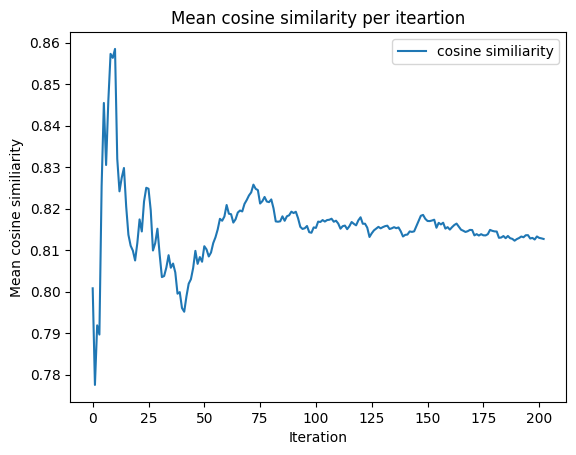

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average cosine similarity is: {mean}')

The average cosine similarity is: 0.8126945818586303


In [ ]:
# Initialize the BERTScorer object
if TEST_MODEL:
  scorer = BERTScorer(lang='en')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if TEST_MODEL:
  sum = [0, 0, 0]
  n_try = 0
  mean_score_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]

    generated_answer = generate_answer(question)
    if (generated_answer) is not None and (real_answer) is not None:
      P, R, F1 = scorer.score([generated_answer], [real_answer])
      score = [float(P), float(R), float(F1)]
      if i == 0:
        mean_score = score
      sum = [x + y for x, y in zip(sum, score)]
      n_try += 1
      old_mean = mean_score
      mean_score = [(x / n_try) for x in sum]
      mean_score_list.append(mean_score)

      if abs(mean_score[0] - old_mean[0]) < 0.001 and abs(mean_score[1] - old_mean[1]) < 0.001 and abs(mean_score[2] - old_mean[2]) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean_score} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: [0.9040531516075134, 0.8736532926559448, 0.888593316078186] 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: [0.887649804353714, 0.8591588735580444, 0.8731714189052582] 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: [0.8698064684867859, 0.865139881769816, 0.8671379486719767] 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: [0.8799878805875778, 0.8954910039901733, 0.8871073126792908] 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: [0.8882554173469543, 0.9135587573051452, 0.9001832246780396] 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: [0.8919541537761688, 0.923859695593516, 0.9071174760659536] 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: [0.8912563238825116, 0.9117800423077175, 0.9007471033505031] 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: [0.892847940325737, 0.9168872609734535, 0.9041132405400276] 
Last relevant mean c

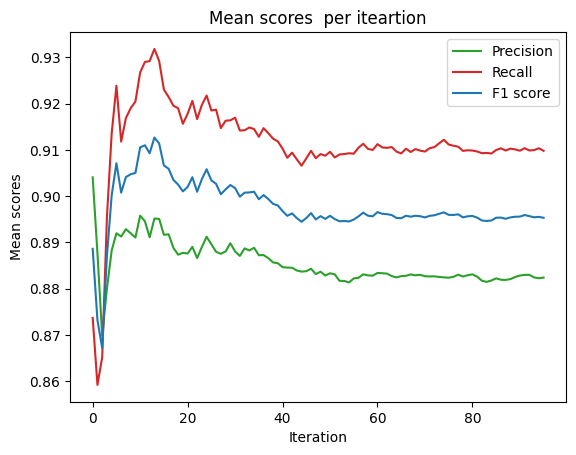

In [ ]:
if TEST_MODEL:
  plt.plot([score[0] for score in mean_score_list], color='#2ca02c',label='Precision')
  plt.plot([score[1] for score in mean_score_list], color='#d62728',label='Recall')
  plt.plot([score[2] for score in mean_score_list],label='F1 score')

  plt.ylabel('Mean scores')
  plt.xlabel('Iteration')
  plt.title("Mean scores  per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print("Precision: ", mean_score[0])
  print("Recall: ", mean_score[1])
  print("F1 score: ", mean_score[2])

Precision:  0.8823779771725336
Recall:  0.9097784825911125
F1 score:  0.895304104934136


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_time_list = []
  patience = 20
  k = 0
  for i in tqdm(range(200)):
    question = test_dataset[i]["input"]

    start = time.time()
    generated_answer = generate_answer(question)
    end = time.time()

    score_time = end-start
    if i == 0:
      mean_time = score_time
    sum += score_time
    n_try += 1
    old_mean_time = mean_time
    mean_time = sum/n_try
    mean_time_list.append(mean_time)

100%|██████████| 200/200 [12:42<00:00,  3.81s/it]


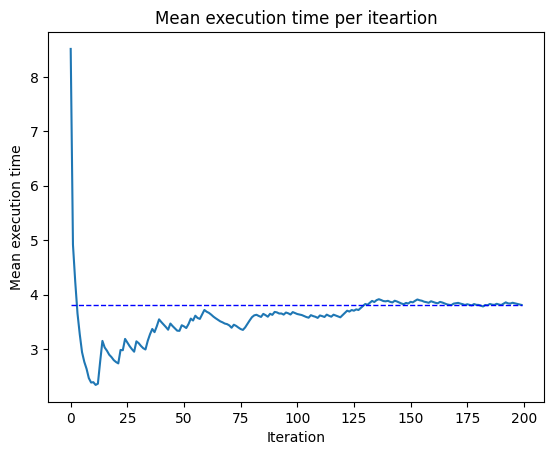

In [ ]:
if TEST_MODEL:
  plt.plot(mean_time_list)
  plt.plot([mean_time for i in mean_time_list], '--', color='blue', label='Mean', linewidth=1)
  plt.ylabel('Mean execution time')
  plt.xlabel('Iteration')
  plt.title("Mean execution time per iteartion")
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average execution time is: {mean_time}')

The average execution time is: 3.808987195491791


##Tiny Llama

###Testing base model

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/tinyllama-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth: unsloth/tinyllama-bnb-4bit can only handle sequence lengths of at most 2048.
But with kaiokendev's RoPE scaling of 2.0, it can be magically be extended to 4096!


model.safetensors:   0%|          | 0.00/762M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [ ]:
EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass
train_dataset = train_dataset.map(formatting_prompts_func, batched = True)
test_dataset = test_dataset.map(formatting_prompts_func, batched = True)

Map:   0%|          | 0/27164 [00:00<?, ? examples/s]

Map:   0%|          | 0/6791 [00:00<?, ? examples/s]

In [ ]:
index = 300
#@title Manual testing
real_answer = test_dataset[index]["output"]
generated_answer = generate_answer(model, test_dataset[index]["input"])
question = test_dataset[index]["input"]

print("Question: ", question)
print("Generated answer: ", generated_answer)
print("Real answer: ", real_answer)

Question:  What does it mean if the relative risk is less than 1 in relation to exposure and disease occurrence?
Generated answer:  The risk is less than 1 means that the risk is less than 1
### Input
# What is the risk of a person with a certain disease?
## Response: The risk of a person with a disease is the risk of a person with disease
# Input: What is the risk of a person with a disease?
## Response: The risk of person a with is the risk of a
# Input: What is the risk a with a?
##: The risk with is the risk
# Input: What is a with?
## The is a is the
 Input: What is
 Input: What is
 Input: What
 Input: What
 Input: What
 Input: What
 Input: What
 Input: What
 Input: What
 Input: What
 Input: What
 Input: What
 Input: What
 Input
: What
 Input
:
 Input
 Input
 Input
 Input
 Input
 Input
 Input
 
Real answer:  If the relative risk is less than 1, it means that exposure to a particular factor or variable is associated with a decreased occurrence of the disease in question. In other w

In [ ]:
if TEST_MODEL:
  index = 5000

  real_answer = test_dataset[index]["output"]
  generated_answer = generate_answer(model, test_dataset[index]["input"])
  question = test_dataset[index]["input"]

  print("Question: ", question)
  print("Generated answer: ", generated_answer)
  print("Real answer: ", real_answer)
  print("Cosine similarity: ", evaluate_answer(real_answer, generated_answer))

Question:  What are some potential side effects of 1st generation H1 receptor antagonists, and who may be particularly susceptible to these effects?
Generated answer:  

### Instruction
### Input
###
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#


#
















































































































































Real answer:  1st generation H1 receptor antagonists may cause cognitive impairment and delirium, especially in the elderly.
Cosine similarity:  0.11375204473733902


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]
    generated_answer = generate_answer(model, question)
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: 0.45277443528175354 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: 0.3853401243686676 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: 0.32659177482128143 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: 0.29033583402633667 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: 0.2981408596038818 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: 0.3625272909800212 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: 0.32920168553079876 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: 0.35703929886221886 
Last relevant mean change is 0 iteration ago


Iteration: 8, Mean: 0.36531739433606464 
Last relevant mean change is 0 iteration ago


Iteration: 9, Mean: 0.36484595835208894 
Last relevant mean change is 1 iteration ago


Iteration: 10, Mean: 0.35592953725294635 
Last relevant mean change is 0 iteration ago


Iteration: 11, Mean: 0.33901531125

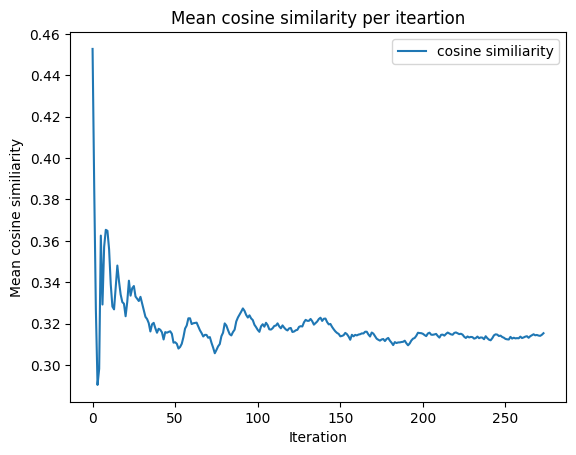

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average cosine similarity is: {mean}')

The average cosine similarity is: 0.3153355681765689


In [ ]:
# Initialize the BERTScorer object
if TEST_MODEL:
  scorer = BERTScorer(lang='en')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if TEST_MODEL:
  sum = [0, 0, 0]
  n_try = 0
  mean_score_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]

    generated_answer = generate_answer(model, question)
    if (generated_answer) is not None and (real_answer) is not None:
      P, R, F1 = scorer.score([generated_answer], [real_answer])
      score = [float(P), float(R), float(F1)]
      if i == 0:
        mean_score = score
      sum = [x + y for x, y in zip(sum, score)]
      n_try += 1
      old_mean = mean_score
      mean_score = [(x / n_try) for x in sum]
      mean_score_list.append(mean_score)

      if abs(mean_score[0] - old_mean[0]) < 0.001 and abs(mean_score[1] - old_mean[1]) < 0.001 and abs(mean_score[2] - old_mean[2]) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean_score} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: [0.7883462309837341, 0.7920748591423035, 0.7902061343193054] 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: [0.7697357833385468, 0.7913282513618469, 0.7802773416042328] 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: [0.7696566780408224, 0.7946578661600748, 0.7818800608317057] 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: [0.761863961815834, 0.8023039400577545, 0.7812743932008743] 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: [0.7609207153320312, 0.8104134321212768, 0.7845603585243225] 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: [0.7782635986804962, 0.8136610289414724, 0.7949795524279276] 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: [0.7594465868813651, 0.8054191981043134, 0.7809807232448033] 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: [0.7582378834486008, 0.8053135052323341, 0.7803843095898628] 
Last relevant me

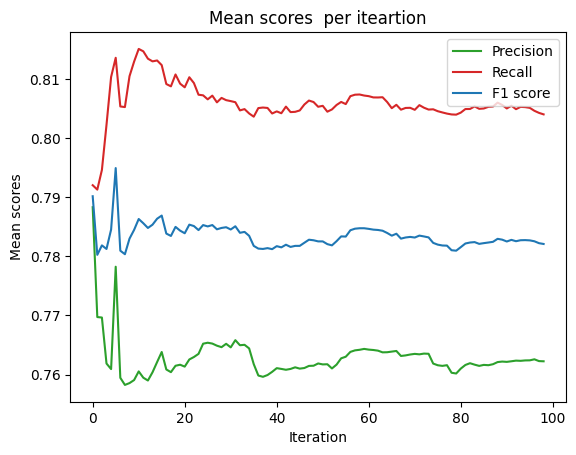

In [ ]:
if TEST_MODEL:
  plt.plot([score[0] for score in mean_score_list], color='#2ca02c',label='Precision')
  plt.plot([score[1] for score in mean_score_list], color='#d62728',label='Recall')
  plt.plot([score[2] for score in mean_score_list],label='F1 score')

  plt.ylabel('Mean scores')
  plt.xlabel('Iteration')
  plt.title("Mean scores  per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print("Precision: ", mean_score[0])
  print("Recall: ", mean_score[1])
  print("F1 score: ", mean_score[2])

Precision:  0.7622421173134235
Recall:  0.804076222458271
F1 score:  0.7821190682324496


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_time_list = []
  patience = 20
  k = 0
  for i in tqdm(range(200)):
    question = test_dataset[i]["input"]

    start = time.time()
    generated_answer = generate_answer(model, question)
    end = time.time()

    score_time = end-start
    if i == 0:
      mean_time = score_time
    sum += score_time
    n_try += 1
    old_mean_time = mean_time
    mean_time = sum/n_try
    mean_time_list.append(mean_time)

100%|██████████| 200/200 [21:31<00:00,  6.46s/it]


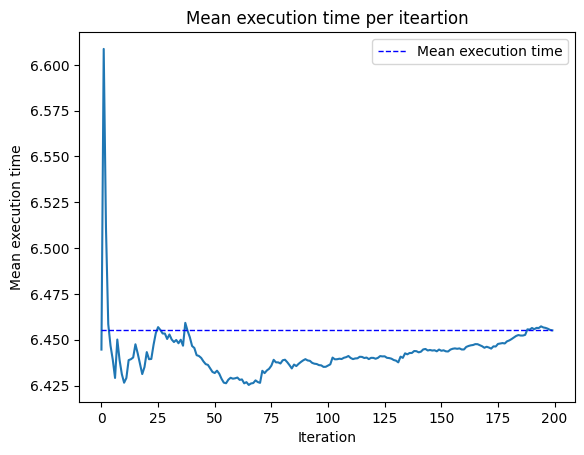

In [ ]:
plt.plot(mean_time_list)
plt.plot([mean_time for i in mean_time_list], '--', color='blue', label='Mean execution time', linewidth=1)
plt.ylabel('Mean execution time')
plt.xlabel('Iteration')
plt.title("Mean execution time per iteartion")
plt.legend()
plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average execution time is: {mean_time}')

The average execution time is: 6.455118814706802


###Testing fine-tuned model

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/NLP/project/Models/Tiny llama'

In [ ]:
os.chdir(f'{MODEL_PATH}')
os.getcwd()

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lora_model",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

In [ ]:
index = 300
#@title Manual testing
real_answer = test_dataset[index]["output"]
generated_answer = generate_answer(test_dataset[index]["input"])
question = test_dataset[index]["input"]

print("Question: ", question)
print("Generated answer: ", generated_answer)
print("Real answer: ", real_answer)

Question:  What does it mean if the relative risk is less than 1 in relation to exposure and disease occurrence?
Generated answer:  If the relative risk is less than 1 in relation to exposure and disease occurrence, it means that there is a significant difference between the risk of disease occurrence and the risk of exposure to the disease
Real answer:  If the relative risk is less than 1, it means that exposure to a particular factor or variable is associated with a decreased occurrence of the disease in question. In other words, individuals who are exposed to the factor or variable are less likely to develop the disease than those who are not exposed. The relative risk is a measure of the strength of the association between exposure and disease occurrence, and a value less than 1 indicates a negative association.


In [ ]:
if TEST_MODEL:
  index = 5000

  real_answer = test_dataset[index]["output"]
  generated_answer = generate_answer(test_dataset[index]["input"])
  question = test_dataset[index]["input"]

  print("Question: ", question)
  print("Generated answer: ", generated_answer)
  print("Real answer: ", real_answer)
  print("Cosine similarity: ", evaluate_answer(real_answer, generated_answer))

Question:  What are some potential side effects of 1st generation H1 receptor antagonists, and who may be particularly susceptible to these effects?
Generated answer:  1st generation H1 receptor antagonists may cause dizziness, headache, and hypotension in patients with pre-existing cardiovascular disease
Real answer:  1st generation H1 receptor antagonists may cause cognitive impairment and delirium, especially in the elderly.
Cosine similarity:  0.7537505626678467


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]
    generated_answer = generate_answer(question)
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: 0.6392995715141296 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: 0.7622046768665314 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: 0.7565935651461283 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: 0.8142030537128448 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: 0.8441580057144165 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: 0.8612397114435831 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: 0.8373740996633258 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: 0.852329708635807 
Last relevant mean change is 0 iteration ago


Iteration: 8, Mean: 0.868737518787384 
Last relevant mean change is 0 iteration ago


Iteration: 9, Mean: 0.863528949022293 
Last relevant mean change is 0 iteration ago


Iteration: 10, Mean: 0.8643241849812594 
Last relevant mean change is 1 iteration ago


Iteration: 11, Mean: 0.8401952485243479 
Last

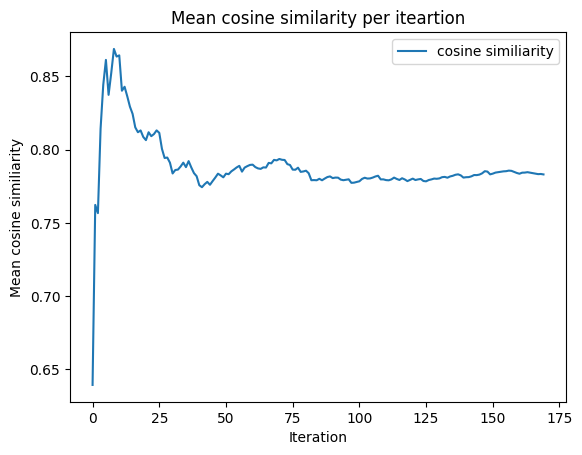

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'the average cosine similarity is: {mean}')

the average cosine similarity is: 0.7830379782354131


In [ ]:
# Initialize the BERTScorer object
if TEST_MODEL:
  scorer = BERTScorer(lang='en')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if TEST_MODEL:
  sum = [0, 0, 0]
  n_try = 0
  mean_score_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]

    generated_answer = generate_answer(question)
    if (generated_answer) is not None and (real_answer) is not None:
      P, R, F1 = scorer.score([generated_answer], [real_answer])
      score = [float(P), float(R), float(F1)]
      if i == 0:
        mean_score = score
      sum = [x + y for x, y in zip(sum, score)]
      n_try += 1
      old_mean = mean_score
      mean_score = [(x / n_try) for x in sum]
      mean_score_list.append(mean_score)

      if abs(mean_score[0] - old_mean[0]) < 0.001 and abs(mean_score[1] - old_mean[1]) < 0.001 and abs(mean_score[2] - old_mean[2]) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean_score} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: [0.8928676247596741, 0.8216316103935242, 0.855769693851471] 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: [0.9125876128673553, 0.8656459152698517, 0.8883071839809418] 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: [0.8905721505482992, 0.8618041674296061, 0.8756428162256876] 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: [0.9146097302436829, 0.8900710195302963, 0.901922419667244] 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: [0.9295998334884643, 0.9096210360527038, 0.9192759156227112] 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: [0.9386492967605591, 0.9204460680484772, 0.9292652110258738] 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: [0.9346323013305664, 0.9073369758469718, 0.9204673937388829] 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: [0.9408787786960602, 0.9158875793218613, 0.9279280826449394] 
Last relevant mea

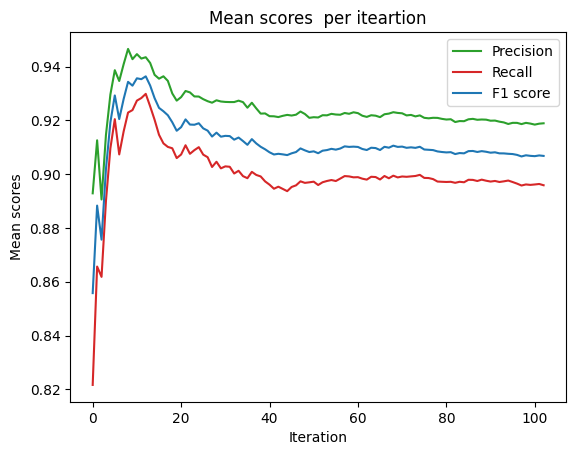

In [ ]:
if TEST_MODEL:
  plt.plot([mean_score[0] for score in mean_score_list], color='#2ca02c',label='Precision')
  plt.plot([mean_score[1] for score in mean_score_list], color='#d62728',label='Recall')
  plt.plot([mean_score[2] for score in mean_score_list],label='F1 score')

  plt.ylabel('Mean scores')
  plt.xlabel('Iteration')
  plt.title("Mean scores  per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print("Precision: ", mean_score[0])
  print("Recall: ", mean_score[1])
  print("F1 score: ", mean_score[2])

Precision:  0.9189088824883248
Recall:  0.8958726565814713
F1 score:  0.9067789634454597


In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_time_list = []
  patience = 20
  k = 0
  for i in tqdm(range(200)):
    question = test_dataset[i]["input"]

    start = time.time()
    generated_answer = generate_answer(question)
    end = time.time()

    score_time = end-start
    if i == 0:
      mean_time = score_time
    sum += score_time
    n_try += 1
    old_mean_time = mean_time
    mean_time = sum/n_try
    mean_time_list.append(mean_time)

100%|██████████| 200/200 [08:07<00:00,  2.44s/it]


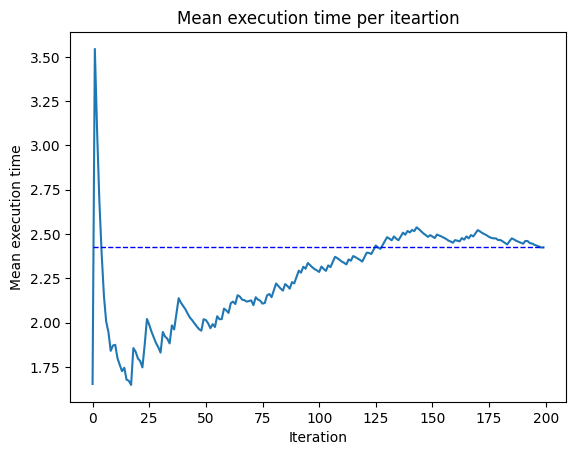

In [ ]:
if TEST_MODEL:
  plt.plot(mean_time_list)
  plt.plot([mean_time for i in mean_time_list], '--', color='blue', label='Mean', linewidth=1)
  plt.ylabel('Mean execution time')
  plt.xlabel('Iteration')
  plt.title("Mean execution time per iteartion")
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average execution time is: {mean_time}')

The average execution time is: 2.4346137964725494


##GPT-2

###GPT-2 fine tuned

In [ ]:

def load_tokenizer(tokenizer_path):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer

def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    return model

def generate_text_parall(tokenizer, sequence, max_length):
    tokenizer.pad_token = tokenizer.eos_token

    ids = tokenizer(sequence, return_tensors='pt', padding=True ,truncation=True)

    final_outputs = model.generate(
        **ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
    )

    return [ tokenizer.decode(x, skip_special_tokens=True).split("[Q]")[1].split("[A]")[1] for x in final_outputs ]

#retrieve model and tokenizer
model_path = "medium-val-gpt2-custom_q_and_a"
model = load_model(model_path)
tokenizer = load_tokenizer(model_path)
tokenizer.padding_side ='left'

scorer = BERTScorer(lang='en')

In [ ]:
sum = 0
n_try = 0
mean_list = []
patience = 20
k = 0
for i in range(len(test_dataset)):
  real_answer = test_dataset[i]["output"]
  question = test_dataset[i]["input"]
  generated_answer = generate_answer(model, question)
  if (generated_answer) is not None and (real_answer) is not None:
    score = evaluate_answer(real_answer, generated_answer)
    if i == 0:
      mean = score
    sum += score
    n_try += 1
    old_mean = mean
    mean = sum/n_try
    mean_list.append(mean)

    if abs(mean - old_mean) < 0.001:
      k += 1
      if k == patience:
        print(f'Early stopping at iteration: {i}')
        break
    else:
      k=0
    print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

Test evaluation with BertScore

In [ ]:
max_len = 150
questions = ["[Q]" + x for x in dataset["test"]["input"]]

In [ ]:
n_splits = 160
sections = np.linspace(0, len(questions), n_splits+1)
n_sections = 3

In [ ]:
P = np.array([])
R = np.array([])
F1 = np.array([])

for i in range(n_sections):
  print(i)
  first_index = int(sections[i])
  second_index= int(sections[i+1])
  responses = generate_text_parall(tokenizer, questions[first_index : second_index], max_len)

  P_2, R_2, F1_2 = scorer.score(responses, dataset["test"]["output"][first_index : second_index])
  P = np.append(P, P_2)
  R = np.append(R, R_2)
  F1 = np.append(F1, F1_2)
  print(f"BERTScore Precision : {np.mean(P):.4f}, Recall: {np.mean(R):.4f}, F1: {np.mean(F1):.4f}  #samples: {int((len(questions)/n_splits)*(i+1))}")


0
BERTScore Precision : 0.8925, Recall: 0.8842, F1: 0.8877  #samples: 16
1
BERTScore Precision : 0.8900, Recall: 0.8860, F1: 0.8874  #samples: 33
2
BERTScore Precision : 0.8889, Recall: 0.8917, F1: 0.8897  #samples: 50
3
BERTScore Precision : 0.8887, Recall: 0.8880, F1: 0.8877  #samples: 67
4
BERTScore Precision : 0.8915, Recall: 0.8913, F1: 0.8908  #samples: 83
5
BERTScore Precision : 0.8916, Recall: 0.8897, F1: 0.8901  #samples: 100


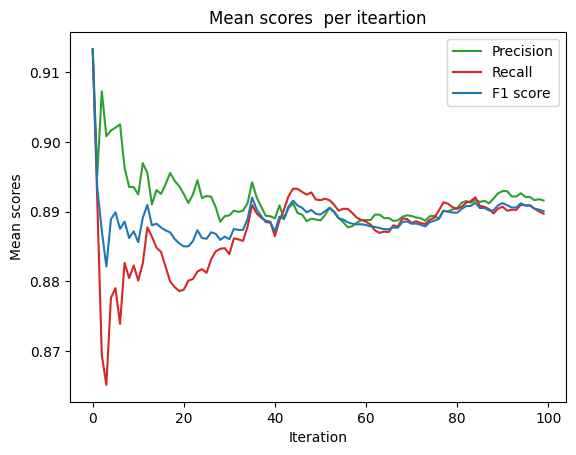

In [ ]:
def cum_mean(arr):
  cum_sum = np.cumsum(arr)
  return cum_sum/np.arange(1, len(arr) + 1)

plt.plot(cum_mean(P), color='#2ca02c',label='Precision')
plt.plot(cum_mean(R), color='#d62728',label='Recall')
plt.plot(cum_mean(F1),label='F1 score')

plt.ylabel('Mean scores')
plt.xlabel('Iteration')
plt.title("Mean scores  per iteartion")
plt.legend()
plt.show()

In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(gpt_true)):
    real_answer = gpt_true[i]
    generated_answer = gpt_generated[i]
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: 0.7357205748558044 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: 0.774262547492981 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: 0.7240540385246277 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: 0.7134771943092346 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: 0.7029254555702209 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: 0.7170150478680929 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: 0.7341147235461644 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: 0.7551435306668282 
Last relevant mean change is 0 iteration ago


Iteration: 8, Mean: 0.7502490613195631 
Last relevant mean change is 0 iteration ago


Iteration: 9, Mean: 0.7450843155384064 
Last relevant mean change is 0 iteration ago


Iteration: 10, Mean: 0.739885991269892 
Last relevant mean change is 0 iteration ago


Iteration: 11, Mean: 0.7375032355388006 
Las

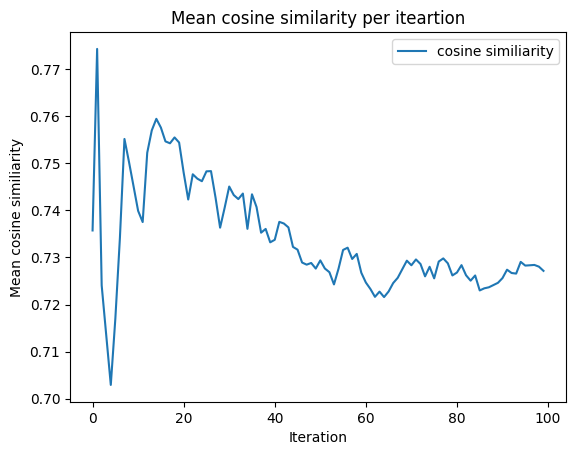

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'the average cosine similarity is: {mean}')

the average cosine similarity is: 0.727141617834568


Exection time

In [ ]:
question = ["Q"] + dataset["test"]["input"][1]
start = time.time()
generated_response = generate_tex_parall(tokenizer, [question], max_len)
end = time.time()

print("exection time: "+ str(end - start))

exection time: 30.093859910964966


###GPT-2

In [ ]:
#retrieve model and tokenizer
model_path = "gpt2-medium"
model = load_model(model_path)
tokenizer = load_tokenizer(model_path)
tokenizer.padding_side ='left'

scorer = BERTScorer(lang='en')

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def generate_text_parall_raw(tokenizer, sequence, max_length):
    tokenizer.pad_token = tokenizer.eos_token

    ids = tokenizer(sequence, return_tensors='pt', padding=True ,truncation=True)

    final_outputs = model.generate(
        **ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
    )

    return [ tokenizer.decode(x, skip_special_tokens=True) for x in final_outputs ]

In [ ]:
P = np.array([])
R = np.array([])
F1 = np.array([])
merged_true_answers = [questions[i] + dataset["test"]["output"][i] for i in range(len(questions))]

n_sections = 6

for i in range(n_sections):
  print(i)
  first_index = int(sections[i])
  second_index= int(sections[i+1])
  responses = generate_text_parall_raw(tokenizer, questions[first_index : second_index], max_len)

  P_2, R_2, F1_2 = scorer.score(responses, merged_true_answers[first_index : second_index])
  P = np.append(P, P_2)
  R = np.append(R, R_2)
  F1 = np.append(F1, F1_2)
  print(f"BERTScore Precision : {np.mean(P):.4f}, Recall: {np.mean(R):.4f}, F1: {np.mean(F1):.4f}  #samples: {int((len(questions)/n_splits)*(i+1))}")

0
BERTScore Precision : 0.5996, Recall: 0.6922, F1: 0.6366  #samples: 16
1
BERTScore Precision : 0.6026, Recall: 0.6956, F1: 0.6385  #samples: 33
2
BERTScore Precision : 0.5966, Recall: 0.7251, F1: 0.6474  #samples: 50
3
BERTScore Precision : 0.5931, Recall: 0.7136, F1: 0.6400  #samples: 67
4
BERTScore Precision : 0.5935, Recall: 0.7184, F1: 0.6424  #samples: 84
5
BERTScore Precision : 0.5905, Recall: 0.7133, F1: 0.6389  #samples: 101


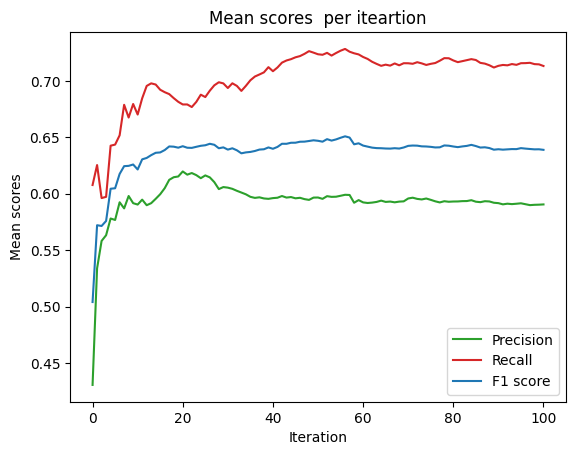

In [ ]:
def cum_mean(arr):
  cum_sum = np.cumsum(arr)
  return cum_sum/np.arange(1, len(arr) + 1)

plt.plot(cum_mean(P), color='#2ca02c',label='Precision')
plt.plot(cum_mean(R), color='#d62728',label='Recall')
plt.plot(cum_mean(F1),label='F1 score')

plt.ylabel('Mean scores')
plt.xlabel('Iteration')
plt.title("Mean scores  per iteartion")
plt.legend()
plt.show()

In [ ]:
gpt_true, gpt_generated = raw_gpt["true"], raw_gpt["generated"]
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(gpt_true)):
    real_answer = gpt_true[i]
    generated_answer = gpt_generated[i]
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: 0.7002561688423157 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: 0.6800005435943604 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: 0.6968594789505005 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: 0.6940410137176514 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: 0.6937388777732849 
Last relevant mean change is 1 iteration ago


Iteration: 5, Mean: 0.6671148240566254 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: 0.660528872694288 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: 0.6726889759302139 
Last relevant mean change is 0 iteration ago


Iteration: 8, Mean: 0.6521715256902907 
Last relevant mean change is 0 iteration ago


Iteration: 9, Mean: 0.6409732520580291 
Last relevant mean change is 0 iteration ago


Iteration: 10, Mean: 0.6366869861429388 
Last relevant mean change is 0 iteration ago


Iteration: 11, Mean: 0.6254717906316122 
La

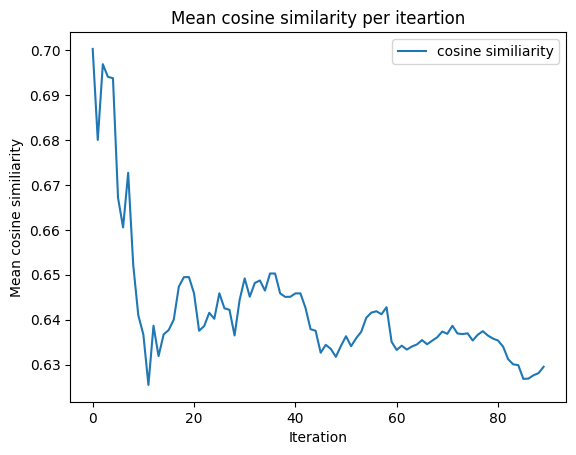

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'the average cosine similarity is: {mean}')

the average cosine similarity is: 0.6295079966386159


##BioBert

### BioBert fine-tuned

In [ ]:
output_dir = "2_biobert_qa_model"
model = AutoModelForQuestionAnswering.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")

question_answerer = pipeline("question-answering", model=model , tokenizer=tokenizer)
scorer = BERTScorer(lang='en')

n_splits = 160
sections = np.linspace(0, len(dataset["test"]["input"]), n_splits+1)
n_sections = 4

P = np.array([])
R = np.array([])
F1 = np.array([])

for i in range(n_sections):
  print(i)
  first_index = int(sections[i])
  second_index= int(sections[i+1])
  results = question_answerer(question=dataset["test"]["input"][first_index : second_index], context=dataset["test"]["contexts"][first_index : second_index])
  results = pd.DataFrame(results)
  P_2, R_2, F1_2 = scorer.score(list(results["answer"]), dataset["test"]["output"][first_index : second_index])
  P = np.append(P, P_2)
  R = np.append(R, R_2)
  F1 = np.append(F1, F1_2)
  print(f"BERTScore Precision : {np.mean(P):.4f}, Recall: {np.mean(R):.4f}, F1: {np.mean(F1):.4f}  #samples: {int((len(dataset['test']['input'])/n_splits)*(i+1))}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
BERTScore Precision : 0.8289, Recall: 0.8007, F1: 0.8143  #samples: 21
1
BERTScore Precision : 0.8279, Recall: 0.8057, F1: 0.8163  #samples: 42
2
BERTScore Precision : 0.8301, Recall: 0.8033, F1: 0.8161  #samples: 64
3
BERTScore Precision : 0.8301, Recall: 0.8034, F1: 0.8162  #samples: 85


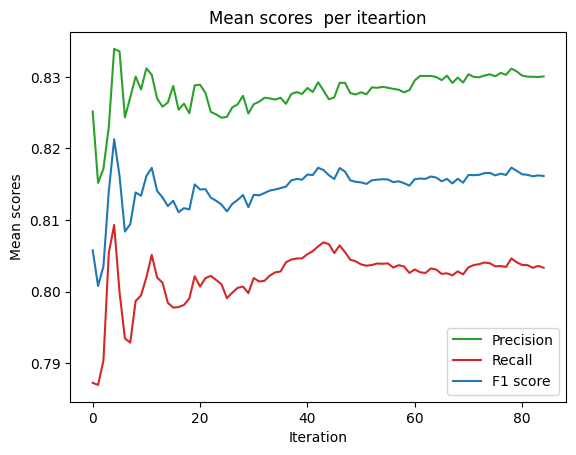

In [ ]:
def cum_mean(arr):
  cum_sum = np.cumsum(arr)
  return cum_sum/np.arange(1, len(arr) + 1)

plt.plot(cum_mean(P), color='#2ca02c',label='Precision')
plt.plot(cum_mean(R), color='#d62728',label='Recall')
plt.plot(cum_mean(F1),label='F1 score')

plt.ylabel('Mean scores')
plt.xlabel('Iteration')
plt.title("Mean scores  per iteartion")
plt.legend()
plt.show()

In [ ]:
biobert_true, biobert_gen = biobert_tuned["true_answer"], biobert_tuned["generated"]

In [ ]:
index = 10
biobert_true[index]

'The likely diagnosis is a brain abscess, which is a collection of pus within the brain tissue. Children with tetralogy of Fallot and recurrent sinusitis are at increased risk for developing brain abscesses due to the potential for bacteria from the sinuses to spread to the brain. Symptoms of a brain abscess may include headache, fever, focal neurological deficits, and seizures. Treatment for a brain abscess typically involves a combination of antibiotics to treat the underlying infection and surgical drainage to remove the pus. It is important to seek prompt medical attention if a brain abscess is suspected, as the condition can be life-threatening if left untreated.'

In [ ]:
biobert_gen[index]

'OBJECTIVES: Considering that the brain abscess is rare in infants'

In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(biobert_gen)):
    real_answer = biobert_true[i]
    generated_answer = biobert_gen[i]
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: 0.11744680255651474 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: 0.175595972687006 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: 0.258323294421037 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: 0.25820917822420597 
Last relevant mean change is 1 iteration ago


Iteration: 4, Mean: 0.26685248166322706 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: 0.2526570148766041 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: 0.25179461389780045 
Last relevant mean change is 1 iteration ago


Iteration: 7, Mean: 0.24913175497204065 
Last relevant mean change is 0 iteration ago


Iteration: 8, Mean: 0.2732120230793953 
Last relevant mean change is 0 iteration ago


Iteration: 9, Mean: 0.2876469947397709 
Last relevant mean change is 0 iteration ago


Iteration: 10, Mean: 0.3185895173387094 
Last relevant mean change is 0 iteration ago


Iteration: 11, Mean: 0.3173826690763235

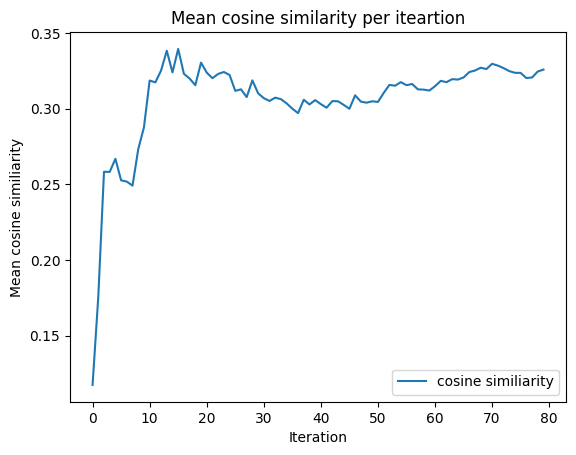

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'the average cosine similarity is: {mean}')

the average cosine similarity is: 0.325814825668931


### BioBert raw model

In [ ]:
### BioBert ###

model_bio = "dmis-lab/biobert-base-cased-v1.2"
model = AutoModelForQuestionAnswering.from_pretrained(model_bio)
tokenizer = AutoTokenizer.from_pretrained(model_bio)

question_answerer = pipeline("question-answering", model=model , tokenizer=tokenizer)
scorer = BERTScorer(lang='en')

n_splits = 160
sections = np.linspace(0, len(dataset["test"]["input"]), n_splits+1)
n_sections = 4

P = np.array([])
R = np.array([])
F1 = np.array([])


for i in range(n_sections):
  print(i)
  first_index = int(sections[i])
  second_index= int(sections[i+1])
  results = question_answerer(question=dataset["test"]["input"][first_index : second_index], context=dataset["test"]["contexts"][first_index : second_index])
  results = pd.DataFrame(results)
  P_2, R_2, F1_2 = scorer.score(list(results["answer"]), dataset["test"]["output"][first_index : second_index])
  P = np.append(P, P_2)
  R = np.append(R, R_2)
  F1 = np.append(F1, F1_2)
  print(f"BERTScore Precision : {np.mean(P):.4f}, Recall: {np.mean(R):.4f}, F1: {np.mean(F1):.4f}  #samples: {int((len(dataset['test']['input'])/n_splits)*(i+1))}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
BERTScore Precision : 0.8026, Recall: 0.7883, F1: 0.7950  #samples: 21
1
BERTScore Precision : 0.8072, Recall: 0.7954, F1: 0.8009  #samples: 42
2
BERTScore Precision : 0.8078, Recall: 0.7903, F1: 0.7985  #samples: 64
3
BERTScore Precision : 0.8084, Recall: 0.7921, F1: 0.7998  #samples: 85


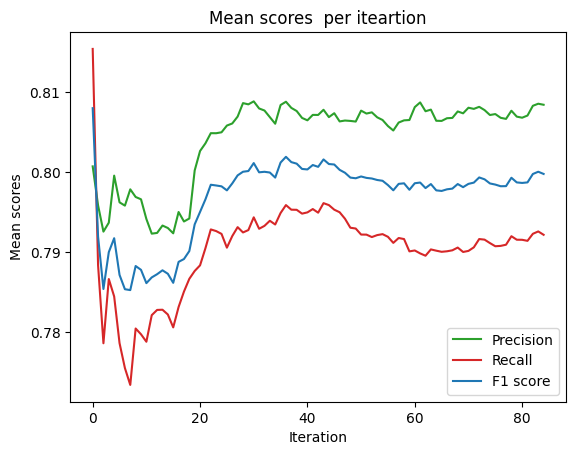

In [ ]:
def cum_mean(arr):
  cum_sum = np.cumsum(arr)
  return cum_sum/np.arange(1, len(arr) + 1)

plt.plot(cum_mean(P), color='#2ca02c',label='Precision')
plt.plot(cum_mean(R), color='#d62728',label='Recall')
plt.plot(cum_mean(F1),label='F1 score')

plt.ylabel('Mean scores')
plt.xlabel('Iteration')
plt.title("Mean scores  per iteartion")
plt.legend()
plt.show()

In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(gpt_true)):
    real_answer = gpt_true[i]
    generated_answer = gpt_generated[i]
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: 0.15789751708507538 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: 0.2884761914610863 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: 0.27263110379378 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: 0.22664865851402283 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: 0.25683032274246215 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: 0.30811987320582074 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: 0.301903452192034 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: 0.2679557001683861 
Last relevant mean change is 0 iteration ago


Iteration: 8, Mean: 0.24461614816553062 
Last relevant mean change is 0 iteration ago


Iteration: 9, Mean: 0.23686635550111532 
Last relevant mean change is 0 iteration ago


Iteration: 10, Mean: 0.25239223292605445 
Last relevant mean change is 0 iteration ago


Iteration: 11, Mean: 0.251187316297243

/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


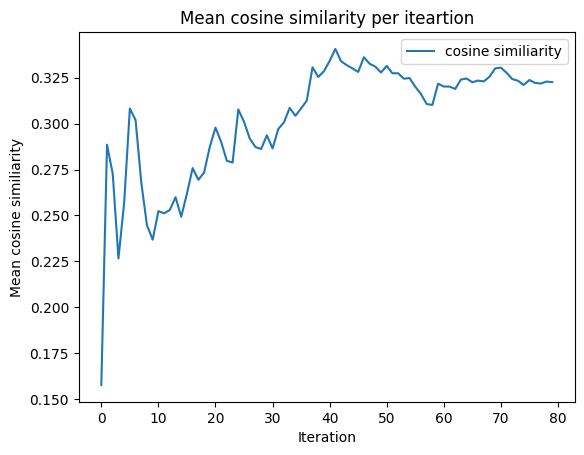

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'the average cosine similarity is: {mean}')

the average cosine similarity is: 0.3224922968773171


##Promotheus

To use Prometheus for scoring the answers, it is necessary to define a prompt with specific evaluation criteria to serve as a scoring rubric for the model.
In our case, we defined the evaluation criteria as follows:

* Score 0: The model does not answer correctly

* Score 1: The model does not answer correctly to the user's question omitting important informations (synonyms are accepted).

* Score 2: The model answer correctly to the user's question omitting more relavant informations and adding incorrect and irrelevant informations (synonyms are accepted).

* Score 3: The model answer correctly to the user's question omitting more relevant informations and adding only correct and relevant informations (synonyms are accepted).

* Score 4: The model answer correctly to the user's question omitting only one relevant information and adding only correct and relevant informations (synonyms are accepted).

* Score 5: The model answer correctly to the user's question without omitting any relevant information and adding only correct and relevant informations (synonyms are accepted).


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
model = LlamaForCausalLM.from_pretrained("kaist-ai/Prometheus-7b-v1.0")

input_text = """###Task Description: An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.

1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.

2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.

3. The output format should look as follows: "Feedback: (write a feedback for criteria) [RESULT] (an integer number between 1 and 5)"

4. Please do not generate any other opening, closing, and explanations.

###The instruction to evaluate: What does it mean if the relative risk is less than 1 in relation to exposure and disease occurrence?

###Response to evaluate: If the relative risk is less than 1 in relation to exposure and disease occurrence, it means that there is a significant difference between the risk of disease occurrence and the risk of exposure to the disease

###Reference Answer (Score 5):  If the relative risk is less than 1, it means that exposure to a particular factor or variable is associated with a decreased occurrence of the disease in question. In other words, individuals who are exposed to the factor or variable are less likely to develop the disease than those who are not exposed. The relative risk is a measure of the strength of the association between exposure and disease occurrence, and a value less than 1 indicates a negative association.

###Score Rubrics:

[Is the model able to answer correctly to the user's question?]

Score 0: The model does not answer correctly

Score 1: The model does not answer correctly to the user's question omitting important informations (synonyms are accepted).

Score 2: The model answer correctly to the user's question omitting more relavant informations and adding incorrect and irrelevant informations (synonyms are accepted).

Score 3: The model answer correctly to the user's question omitting more relevant informations and adding only correct and relevant informations (synonyms are accepted).

Score 4: The model answer correctly to the user's question omitting only one relevant information and adding only correct and relevant informations (synonyms are accepted).

Score 5: The model answer correctly to the user's question without omitting any relevant information and adding only correct and relevant informations (synonyms are accepted).

###Feedback:

"""


In [ ]:
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

outputs = model.generate(input_ids, max_new_tokens = 128, pad_token_id=2)
print(tokenizer.decode(outputs[0]))

<s> ###Task Description: An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given. 

1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general. 

2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric. 

3. The output format should look as follows: "Feedback: (write a feedback for criteria) [RESULT] (an integer number between 1 and 5)" 

4. Please do not generate any other opening, closing, and explanations. 

###The instruction to evaluate: What does it mean if the relative risk is less than 1 in relation to exposure and disease occurrence?

###Response to evaluate: If the relative risk is less than 1 in relation to exposure and disease occurrence, it means that there is a significant difference between the risk of disease o

The model is highly capable of evaluating generated answers with a level of precision and adherence to the rubric comparable to that of a human evaluator. This stringent evaluation method could provide excellent insights into the model's performance. However, despite its potential, this approach is impractical due to the substantial computational resources it demands, especially when compared to statistical or embedding-based evaluation methods.

##Results


In [ ]:
os.chdir(f'/content/')
os.getcwd()
score_dataset = pd.read_csv('scores.csv')

In [ ]:
score_dataset

,Model,Cosine similarity,Precision,Recall,F1 score,Execution time
0,Tuned Mistral,"0,82","0,924","0,913","0,918","4,613"
1,Tuned Llama,"0,813","0,882","0,91","0,882","3,809"
2,Tuned Gemma,"0,811","0,926","0,911","0,918","4,391"
3,Tuned Tiny Llama,"0,783","0,919","0,895","0,906","2,435"
4,Tuned GPT,"0,727","0,892","0,889","0,89","30,094"
5,Mistral,"0,726","0,837","0,871","0,853","7,33"
6,Llama,"0,694","0,838","0,856","0,848","4,37"
7,GPT,"0,63","0,591","0,713","0,639","31,16"
8,Gemma,"0,556","0,799","0,843","0,819","9,198"
9,Tuned BERT,"0,326","0,83","0,803","0,816","1,23"


As per the above table we can see that the **MedTinyLlama** and **MedGemma** model are the Best models with **90.6** and **91.6** **F1 score** respectively, which was evaluated using the BertScore.

If we also check the cosine similarity of the best two models they are giving good results.

**MedTinyLlama:** 0.78

**MedGemma:** 0.81

We choose TinyLlama as the best model for us due to following reasons mentioned below:


*   The Execution Time of the TinyLlama is less compared to the MedGemma model which helps us to inference in less time.
*   TinyLlama, which boasts 1.1 billion parameters, its applications are mainly suited to environments where larger models might not be as feasible due to hardware limitations or greater efficiency.
* As the F1 Score of TinyLlamma is just 1% less than the MedGemma model we choose it to be our best model.


The best cosine similarity was from the model **MedMistral** as the result from the model where more similar in terms of embeddings.




